In [5]:
import argparse
import sys
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import wandb

from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from Models_DTI4 import *

from Dataset_Analysis import IG_Dataset

In [6]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = torch.nn.MSELoss()
    def forward(self, output, targets):
        return torch.sqrt(self.mse(output, targets))

In [7]:
# Evaluation Function
#-------------------------------------------------------------------------------------------------------------------------------
def evaluate(Model, loader, criterion, device):
    Model.eval()

    # Initialize variables to accumulate the evaluation results
    total_loss = 0.0
    y_true = []
    y_pred = []
    refined = []

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        for graphbatch in loader:

            graphbatch.to(device)
            targets = graphbatch.y

            # Forward pass
            output = Model(graphbatch).view(-1)
            loss = criterion(output, targets)

            # Accumulate loss and collect the true and predicted values for later use
            total_loss += loss.item()
            y_true.extend(targets.tolist())
            y_pred.extend(output.tolist())
            refined.extend(graphbatch.data[:,0].tolist())


    # Calculate evaluation metrics
    eval_loss = total_loss / len(loader)

    # Pearson Correlation Coefficient
    corr_matrix = np.corrcoef(y_true, y_pred)
    r = corr_matrix[0, 1]

    # R2 Score
    r2_score = 1 - np.sum((np.array(y_true) - np.array(y_pred)) ** 2) / np.sum((np.array(y_true) - np.mean(np.array(y_true))) ** 2)

    # RMSE in pK unit
    min=0
    max=16
    true_labels_unscaled = torch.tensor(y_true) * (max - min) + min
    predictions_unscaled = torch.tensor(y_pred) * (max - min) + min
    criter = RMSELoss()
    rmse = criter(predictions_unscaled, true_labels_unscaled)

    return eval_loss, r, rmse, r2_score, y_true, y_pred, refined
#-------------------------------------------------------------------------------------------------------------------------------

In [8]:
# Where the inference should run
device_idx = 1

# Location of the test data
test_data_dir = '/data/grbv/PDBbind/DTI_4b/input_graphs_esm2_t6_8M/test_data/casf2016'
train_data_dir = '/data/grbv/PDBbind/DTI_4b/input_graphs_esm2_t6_8M/training_data'
embedding = True
edge_features = True
test_dataset = IG_Dataset(test_data_dir, embedding=embedding, edge_features=edge_features)
train_dataset = IG_Dataset(train_data_dir, embedding=embedding, edge_features=edge_features)

node_feat_dim = train_dataset[0].x_prot_emb.shape[1]
edge_feat_dim = train_dataset[0].edge_attr.shape[1]

train_loader = DataLoader(dataset = train_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)


In [9]:
# Device Settings
num_threads = torch.get_num_threads() // 2
torch.set_num_threads(num_threads)

torch.cuda.set_device(device_idx)
device = torch.device(f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu')
print(device, torch.cuda.current_device(), torch.cuda.get_device_name())

cuda:1 1 NVIDIA A100 80GB PCIe


In [11]:
# Model Settings
model_arch = 'GAT0'
dropout_prob = 0.1
conv_dropout = 0.1
state_dict_path = '/home/grabeda2/DTI/data/DTI4b/r01_611b_add_001_none_d11_f4_best_stdict.pt'


model_class = getattr(sys.modules[__name__], model_arch)
eval_model = model_class(dropout_prob=dropout_prob, in_channels=node_feat_dim, edge_dim=edge_feat_dim, conv_dropout_prob=conv_dropout).to(device)
eval_model = eval_model.double()

eval_model.load_state_dict(torch.load(state_dict_path))

criterion = RMSELoss()

In [7]:
# def residuals_plot(train_y_true, train_y_pred, title, label):
#     axislim = 1.1
#     fig = plt.figure(figsize=(12, 12))  # Set the figure size as needed

#     plt.style.use('ggplot')
#     train_residuals = np.array(train_y_true) - np.array(train_y_pred)

#     # Plot training residuals in blue
#     plt.scatter(train_y_pred, train_residuals, c='blue', label=label, alpha=0.5)

#     plt.xlabel('Predicted Values')
#     plt.ylabel('Residuals')
#     plt.xlim(-0.1, axislim)
#     plt.axhline(y=0, color='r', linestyle='--')
#     plt.title(title)
#     plt.legend()  # Add a legend to differentiate training and validation data
#     plt.show()
#     return fig

In [8]:
# # Plotting Functions
# #-------------------------------------------------------------------------------------------------------------------------
# def plot_predictions(y_true, y_pred, title, label):
    
#     axislim = 1.1
#     fig = plt.figure(figsize=(12, 12))  # Set the figure size as needed

#     plt.scatter(y_true, y_pred, alpha=0.5, c='blue', label=label)

#     plt.plot([min(y_true), axislim], [min(y_true), axislim], color='red', linestyle='--')
#     plt.xlabel('True Values')
#     plt.ylabel('Predicted Values')
#     plt.ylim(-0.1, axislim)
#     plt.xlim(-0.1, axislim)
#     plt.axhline(0, color='grey', linestyle='--')
#     plt.axvline(0, color='grey', linestyle='--')
#     plt.title(title)
    
#     # Adding manual legend items for colors
#     legend_elements = []
#     legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=8, label=label))


#     plt.legend(handles=legend_elements, loc='upper left')
#     return fig

In [12]:
def residuals_plot(ax, y_true, y_pred, title, label, y_lim):
    axislim = 1.1

    plt.style.use('ggplot')
    train_residuals = np.array(y_true) - np.array(y_pred)

    # Plot training residuals in blue
    ax.scatter(y_pred, train_residuals, c='blue', label=label, alpha=0.5)

    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_xlim(-0.1, axislim)
    ax.set_ylim(-y_lim, y_lim)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(title)

In [13]:
def plot_predictions(ax, y_true, y_pred, title, label):
    axislim = 1.1

    plt.style.use('ggplot')
    ax.scatter(y_true, y_pred, alpha=0.5, c='blue', label=label)

    ax.plot([min(y_true), axislim], [min(y_true), axislim], color='red', linestyle='--')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.set_ylim(-0.1, axislim)
    ax.set_xlim(-0.1, axislim)
    ax.axhline(0, color='grey', linestyle='--')
    ax.axvline(0, color='grey', linestyle='--')
    ax.set_title(title)

## Plot the Affinity Metrics

In [14]:
#affmetric_encoding = {'Ki':1., 'Kd':2.,'IC50':3.}

test_Ki_idx = []
test_Kd_idx = []
test_IC50_idx = []

for i, datapoint in enumerate(test_dataset): 
    
    if datapoint.data[:,1] == 1: test_Ki_idx.append(i)
    elif datapoint.data[:,1] == 2: test_Kd_idx.append(i)
    elif datapoint.data[:,1] == 3: test_IC50_idx.append(i)
    else: raise Exception



In [15]:
#affmetric_encoding = {'Ki':1., 'Kd':2.,'IC50':3.}

Ki_idx = []
Kd_idx = []
IC50_idx = []

for i, datapoint in enumerate(train_dataset): 
    
    if datapoint.data[:,1] == 1: Ki_idx.append(i)
    elif datapoint.data[:,1] == 2: Kd_idx.append(i)
    elif datapoint.data[:,1] == 3: IC50_idx.append(i)
    else: raise Exception


Ki_dataset = Subset(train_dataset, Ki_idx)
Kd_dataset = Subset(train_dataset, Kd_idx)
IC50_dataset = Subset(train_dataset, IC50_idx)

Ki_loader = DataLoader(dataset = Ki_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
Kd_loader = DataLoader(dataset = Kd_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
IC50_loader = DataLoader(dataset = IC50_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

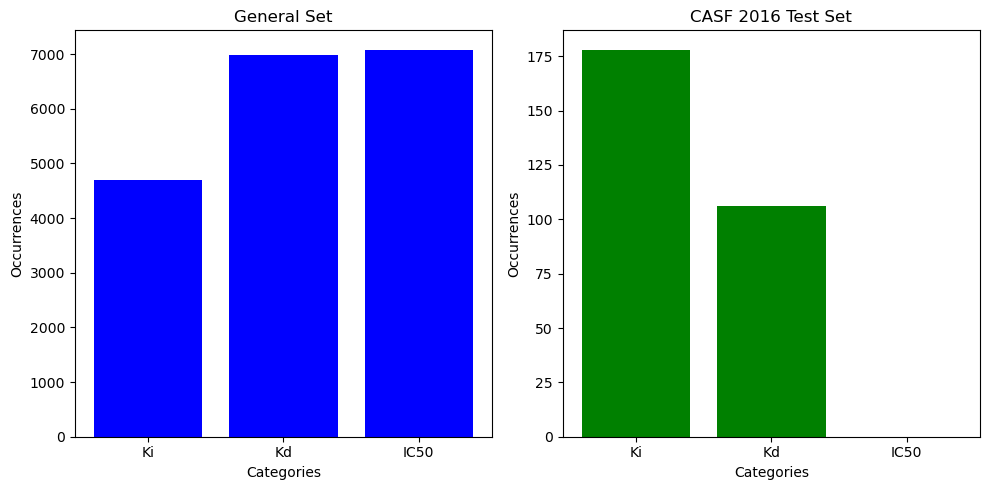

In [16]:
test_n_metric = [len(test_Ki_idx), len(test_Kd_idx), len(test_IC50_idx)]
train_n_metric = [len(Ki_idx), len(Kd_idx), len(IC50_idx)]
catego = ['Ki', 'Kd', 'IC50']

# Creating a 1x2 subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plotting histograms for data1 and data2
ax1.bar(catego, train_n_metric, color='blue')
ax2.bar(catego, test_n_metric, color='green')

# Adding labels and titles to each subplot
ax1.set_title('General Set')
ax1.set_xlabel('Categories')
ax1.set_ylabel('Occurrences')

ax2.set_title('CASF 2016 Test Set')
ax2.set_xlabel('Categories')
ax2.set_ylabel('Occurrences')

# Adjusting the layout
plt.tight_layout()

# Showing the plot
plt.show()




In [17]:
Ki_metrics = evaluate(eval_model, Ki_loader, criterion, device)
Kd_metrics = evaluate(eval_model, Kd_loader, criterion, device)
IC50_metrics = evaluate(eval_model, IC50_loader, criterion, device)

In [13]:
#eval_loss, r, rmse, r2_score, y_true, y_pred, refined

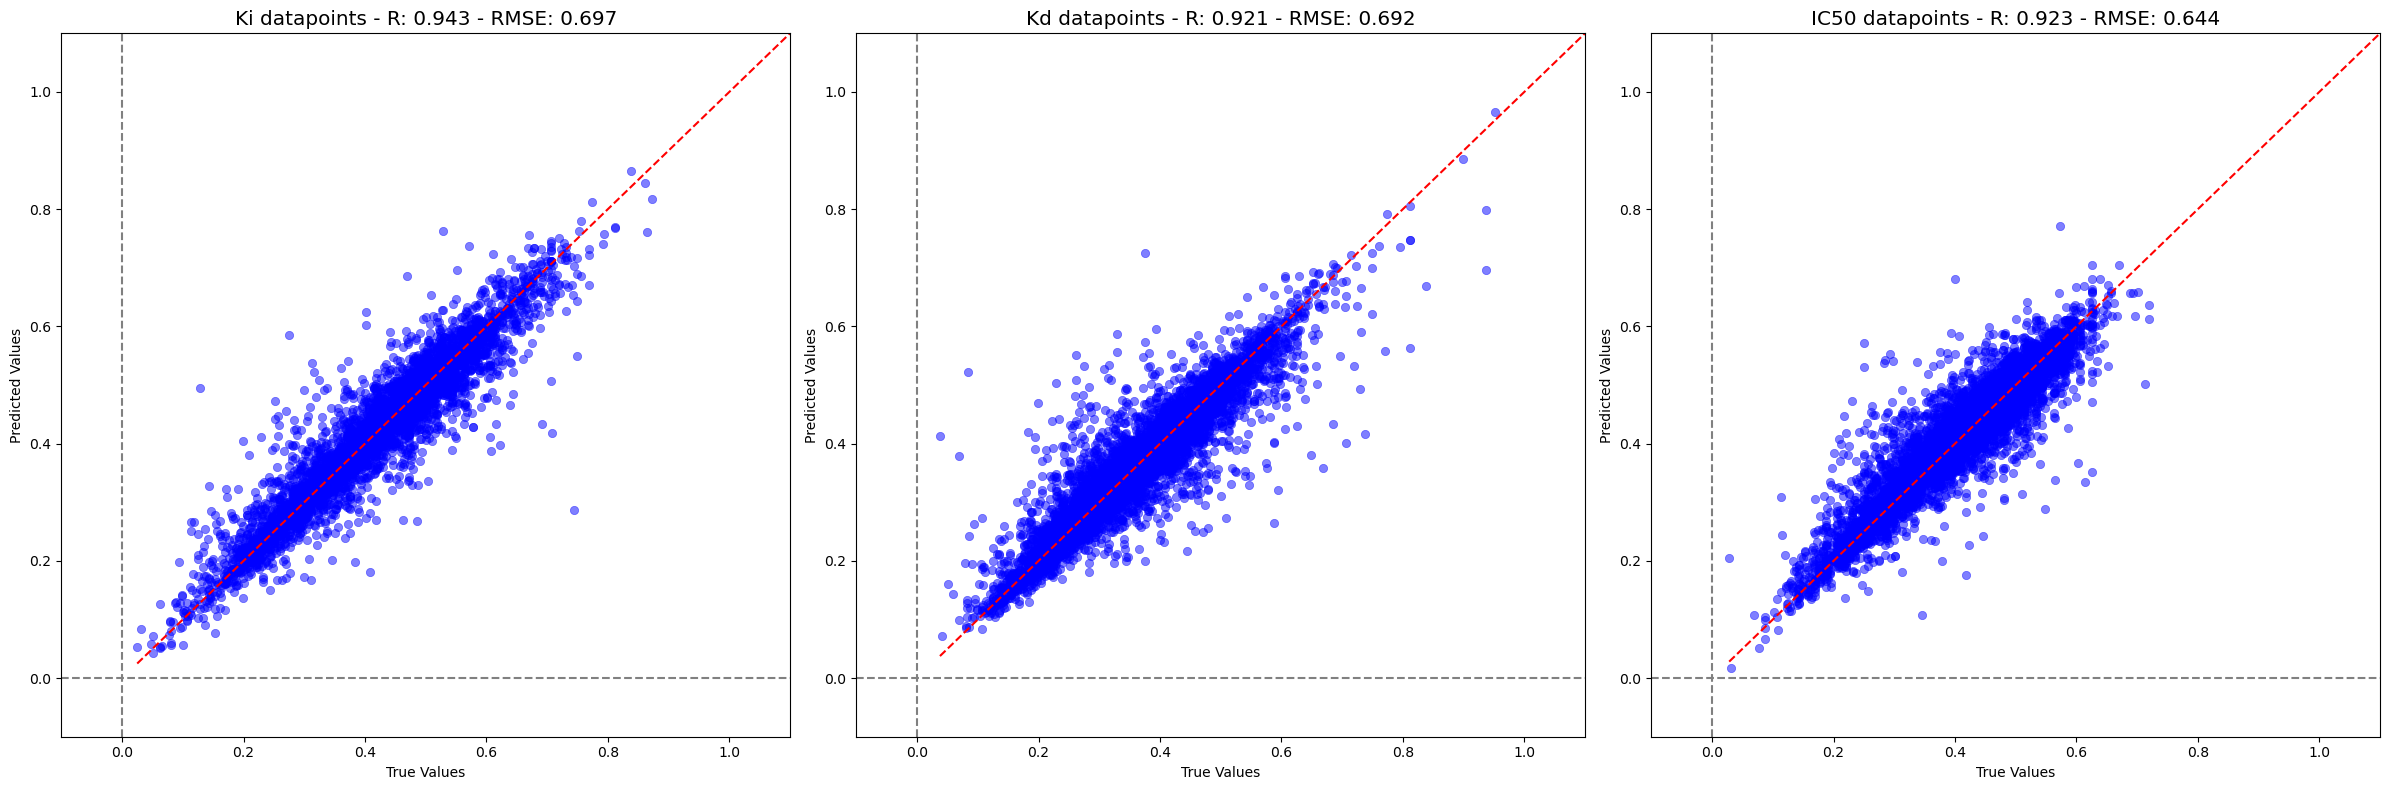

In [18]:
# Create a figure with 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Call the function for each dataset and subplot
plot_predictions(axes[0], Ki_metrics[4], Ki_metrics[5], f"Ki datapoints - R:{Ki_metrics[1]:6.3f} - RMSE:{Ki_metrics[2]:6.3f}", 'Ki')
plot_predictions(axes[1], Kd_metrics[4], Kd_metrics[5], f"Kd datapoints - R:{Kd_metrics[1]:6.3f} - RMSE:{Kd_metrics[2]:6.3f}", 'Kd')
plot_predictions(axes[2], IC50_metrics[4], IC50_metrics[5], f"IC50 datapoints - R:{IC50_metrics[1]:6.3f} - RMSE:{IC50_metrics[2]:6.3f}", 'IC50')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

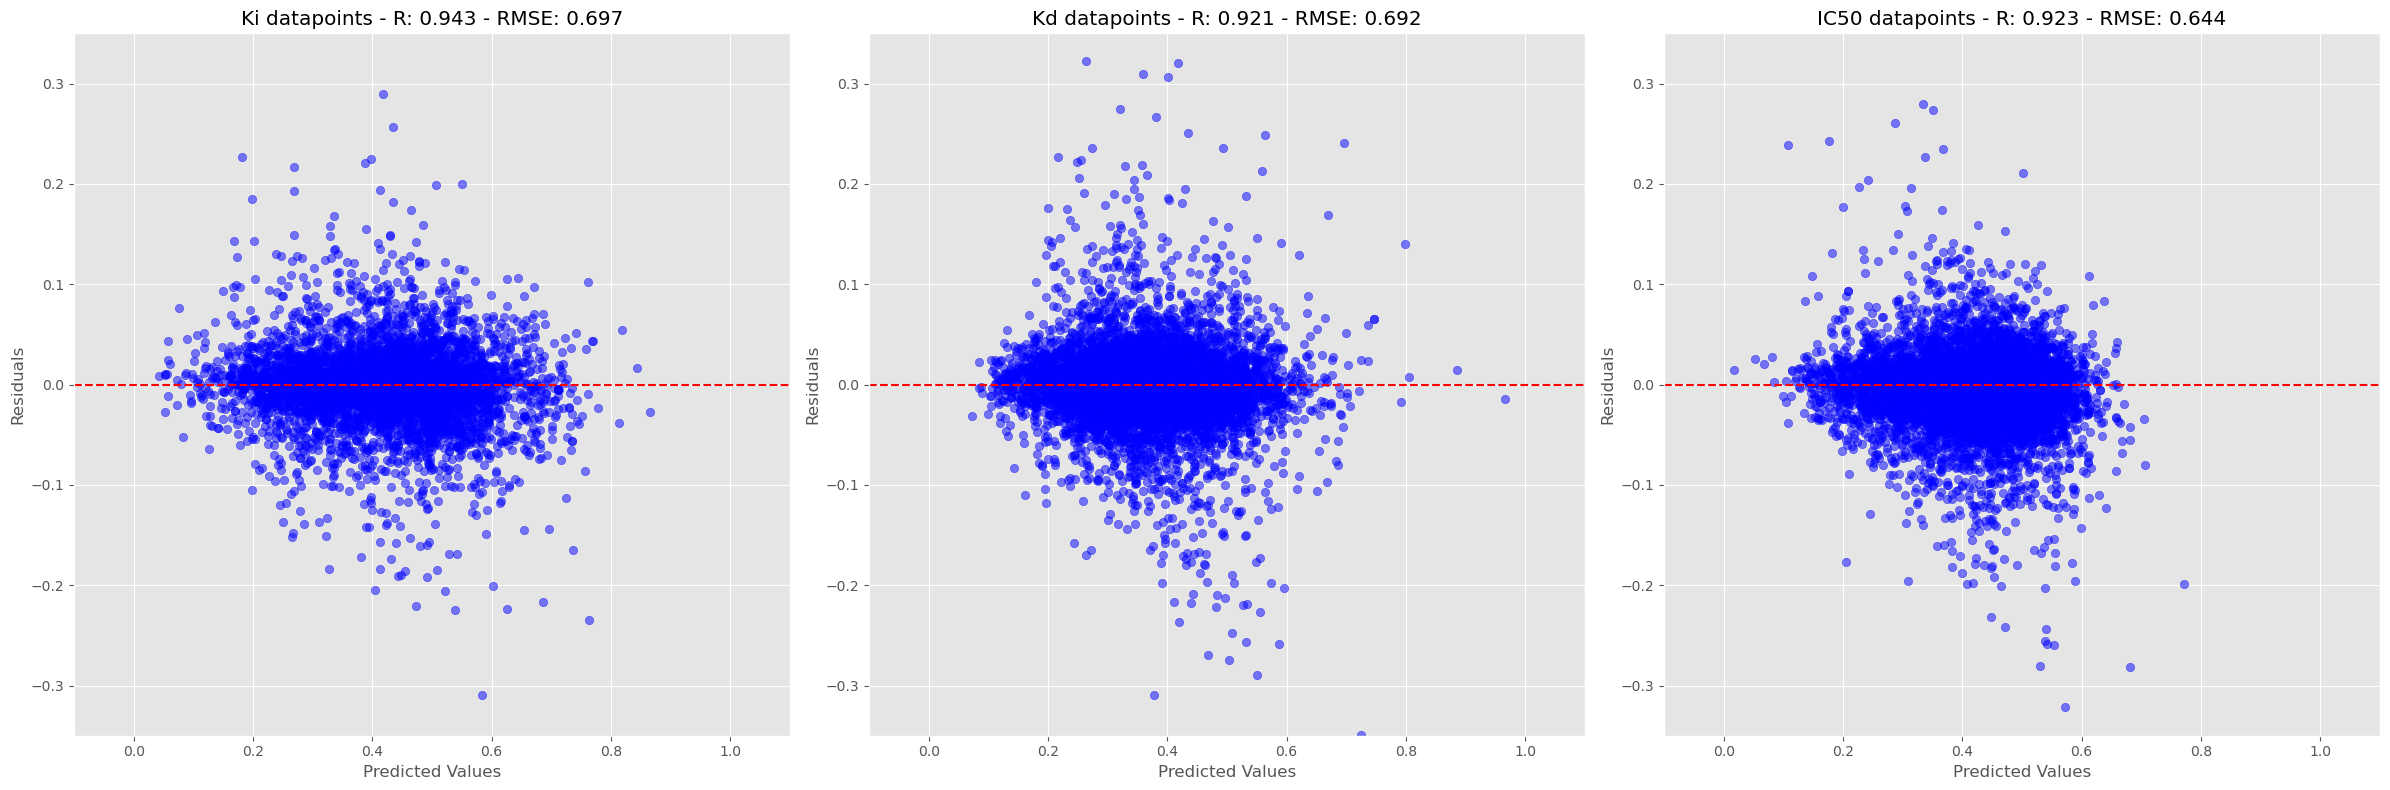

In [19]:
# Create a figure with 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Call the function for each dataset and subplot
residuals_plot(axes[0], Ki_metrics[4], Ki_metrics[5], f"Ki datapoints - R:{Ki_metrics[1]:6.3f} - RMSE:{Ki_metrics[2]:6.3f}", 'Ki', 0.35)
residuals_plot(axes[1], Kd_metrics[4], Kd_metrics[5], f"Kd datapoints - R:{Kd_metrics[1]:6.3f} - RMSE:{Kd_metrics[2]:6.3f}", 'Kd', 0.35)
residuals_plot(axes[2], IC50_metrics[4], IC50_metrics[5], f"IC50 datapoints - R:{IC50_metrics[1]:6.3f} - RMSE:{IC50_metrics[2]:6.3f}", 'IC50', 0.35)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Plot the resolution

In [20]:
test_NMR_idx = []
test_low_idx = []
test_medium_idx = []
test_high_idx = []

for i, datapoint in enumerate(test_dataset): 

    lowest= 0.75
    highest = 4.6

    if datapoint.data[:,2] == 0: test_NMR_idx.append(i)
    elif lowest <= datapoint.data[:,2] < lowest + (1/3)*(highest-lowest): test_high_idx.append(i)
    elif lowest + (1/3)*(lowest-highest) <= datapoint.data[:,2] < lowest + (2/3)*(highest-lowest): test_medium_idx.append(i)
    elif lowest + (2/3)*(highest-lowest) <= datapoint.data[:,2] <= highest: test_low_idx.append(i)

    else: raise Exception

1.904401408450704


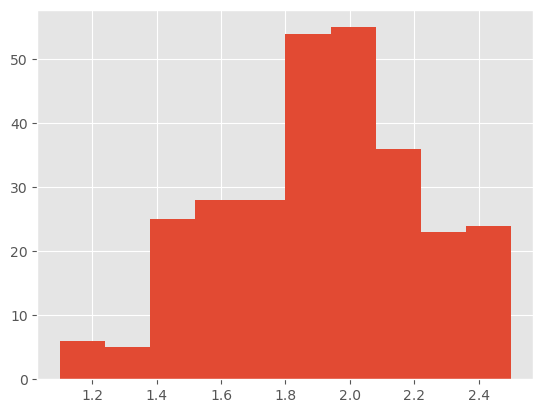

In [21]:
resolu = []
for datapoint in test_dataset:
    resolu.append(datapoint.data[:,2].item())

plt.hist(resolu)
print(np.mean(resolu))

2.054382196162047


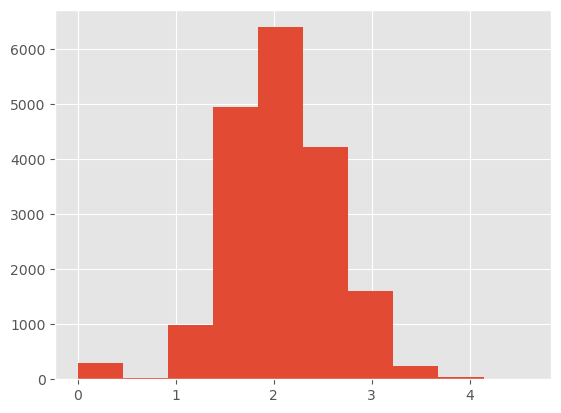

In [22]:
resolu = []
for datapoint in train_dataset:
    resolu.append(datapoint.data[:,2].item())

plt.hist(resolu)
print(np.mean(resolu))

In [23]:
NMR_idx = []
low_idx = []
medium_idx = []
high_idx = []

for i, datapoint in enumerate(train_dataset): 

    lowest= 0.75
    highest = 4.6

    if datapoint.data[:,2] == 0: NMR_idx.append(i)
    elif lowest <= datapoint.data[:,2] < lowest + (1/3)*(highest-lowest): high_idx.append(i)
    elif lowest + (1/3)*(lowest-highest) <= datapoint.data[:,2] < lowest + (2/3)*(highest-lowest): medium_idx.append(i)
    elif lowest + (2/3)*(highest-lowest) <= datapoint.data[:,2] <= highest: low_idx.append(i)

    else: raise Exception

nmr_dataset = Subset(train_dataset, NMR_idx)
high_dataset = Subset(train_dataset, high_idx)
medium_dataset = Subset(train_dataset, medium_idx)
low_dataset = Subset(train_dataset, low_idx)

NMR_loader = DataLoader(dataset = nmr_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
high_loader = DataLoader(dataset = high_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
medium_loader = DataLoader(dataset = medium_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
low_loader = DataLoader(dataset = low_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

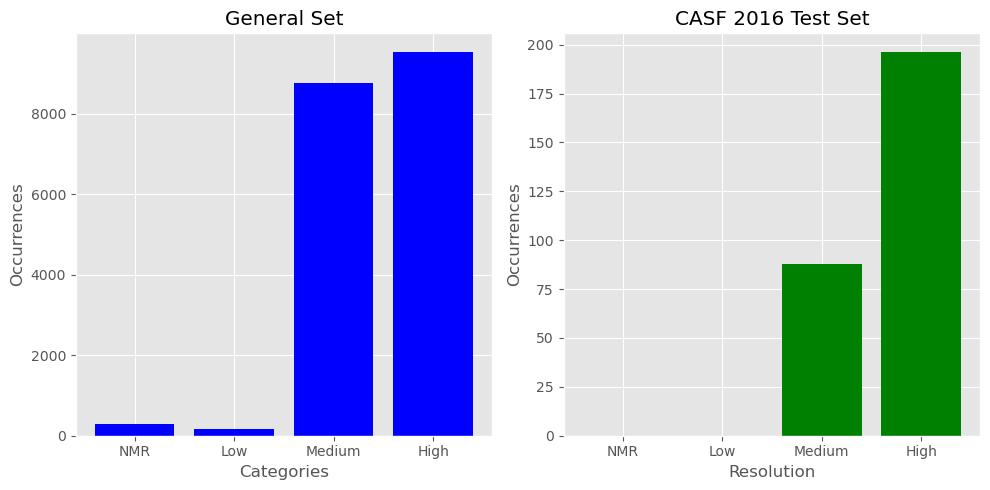

In [24]:
test_n_resolution = [len(test_NMR_idx), len(test_low_idx), len(test_medium_idx), len(test_high_idx)]
train_n_resolution = [len(NMR_idx), len(low_idx), len(medium_idx), len(high_idx)]
catego = ['NMR', 'Low', 'Medium', 'High']

# Creating a 1x2 subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plotting histograms for data1 and data2
ax1.bar(catego, train_n_resolution, color='blue')
ax2.bar(catego, test_n_resolution, color='green')

# Adding labels and titles to each subplot
ax1.set_title('General Set')
ax1.set_xlabel('Categories')
ax1.set_ylabel('Occurrences')

ax2.set_title('CASF 2016 Test Set')
ax2.set_xlabel('Resolution')
ax2.set_ylabel('Occurrences')

# Adjusting the layout
plt.tight_layout()

# Showing the plot
plt.show()

In [25]:
nmr_metrics = evaluate(eval_model, NMR_loader, criterion, device)
high_metrics = evaluate(eval_model, high_loader, criterion, device)
medium_metrics = evaluate(eval_model, medium_loader, criterion, device)
low_metrics = evaluate(eval_model, low_loader, criterion, device)

In [26]:
for loader in [NMR_loader, high_loader, medium_loader, low_loader]:
    print(len(loader.dataset))

302
9516
8766
176


In [27]:
def plot_predictions(ax, y_true, y_pred, title, refined):
    axislim = 1.1

    cmap = {0: 'blue', 1: 'red'}
    point_colors = [cmap[color] for color in refined]

    plt.style.use('ggplot')
    ax.scatter(y_true, y_pred, alpha=0.5, c=point_colors)
    

    ax.plot([min(y_true), axislim], [min(y_true), axislim], color='red', linestyle='--')
    ax.set_xlabel('True Values', fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=12)
    ax.set_ylim(0, axislim)
    ax.set_xlim(0, axislim)
    ax.axhline(0, color='grey', linestyle='--')
    ax.axvline(0, color='grey', linestyle='--')
    ax.set_title(title)

In [28]:
def residuals_plot(ax, y_true, y_pred, title, y_lim, refined):
    axislim = 1.1

    cmap = {0: 'blue', 1: 'red'}
    point_colors = [cmap[color] for color in refined]

    plt.style.use('ggplot')
    train_residuals = np.array(y_true) - np.array(y_pred)

    # Plot training residuals in blue
    ax.scatter(y_pred, train_residuals, c=point_colors, alpha=0.5)

    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_xlim(-0.1, axislim)
    ax.set_ylim(-y_lim, y_lim)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(title)

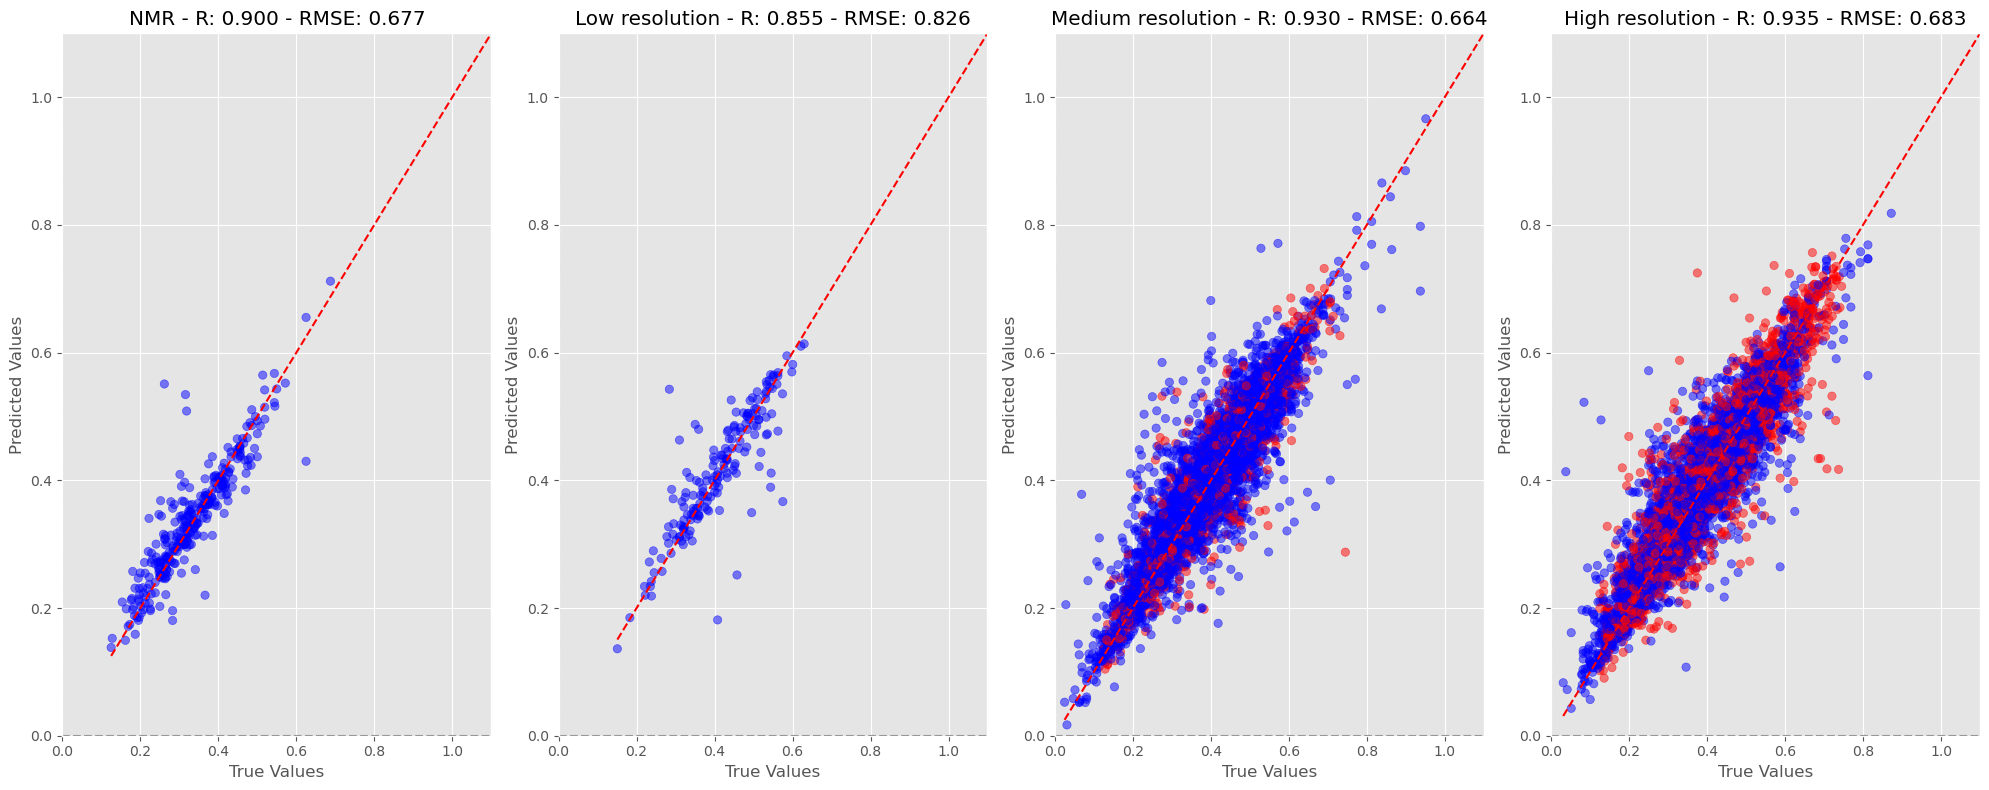

In [29]:
# Create a figure with 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# Call the function for each dataset and subplot
plot_predictions(axes[0], nmr_metrics[4], nmr_metrics[5], f"NMR - R:{nmr_metrics[1]:6.3f} - RMSE:{nmr_metrics[2]:6.3f}", nmr_metrics[6])
plot_predictions(axes[1], low_metrics[4], low_metrics[5], f"Low resolution - R:{low_metrics[1]:6.3f} - RMSE:{low_metrics[2]:6.3f}", low_metrics[6])
plot_predictions(axes[2], medium_metrics[4], medium_metrics[5], f"Medium resolution - R:{medium_metrics[1]:6.3f} - RMSE:{medium_metrics[2]:6.3f}", medium_metrics[6])
plot_predictions(axes[3], high_metrics[4], high_metrics[5], f"High resolution - R:{high_metrics[1]:6.3f} - RMSE:{high_metrics[2]:6.3f}", high_metrics[6])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

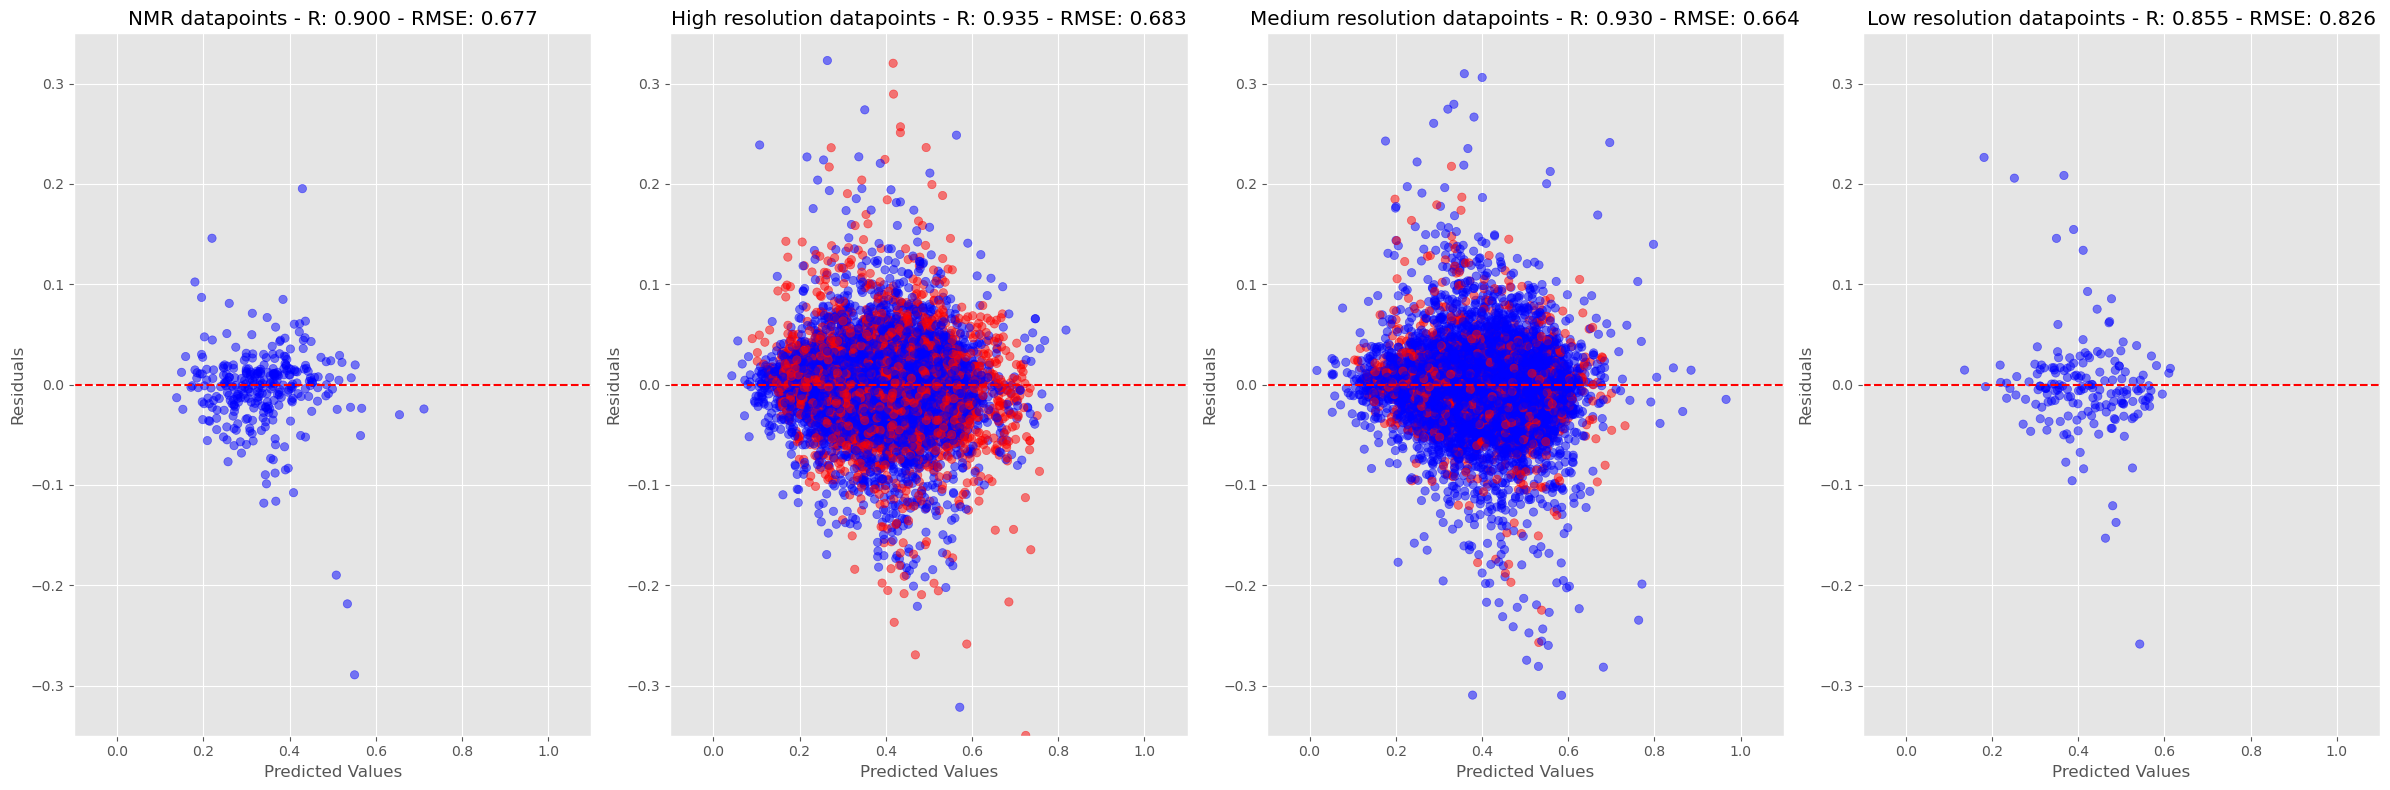

In [30]:
# Create a figure with 1x3 subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 8))

# Call the function for each dataset and subplot
residuals_plot(axes[0], nmr_metrics[4], nmr_metrics[5], f"NMR datapoints - R:{nmr_metrics[1]:6.3f} - RMSE:{nmr_metrics[2]:6.3f}", 0.35, nmr_metrics[6])
residuals_plot(axes[1], high_metrics[4], high_metrics[5], f"High resolution datapoints - R:{high_metrics[1]:6.3f} - RMSE:{high_metrics[2]:6.3f}", 0.35, high_metrics[6])
residuals_plot(axes[2], medium_metrics[4], medium_metrics[5], f"Medium resolution datapoints - R:{medium_metrics[1]:6.3f} - RMSE:{medium_metrics[2]:6.3f}", 0.35, medium_metrics[6])
residuals_plot(axes[3], low_metrics[4], low_metrics[5], f"Low resolution datapoints - R:{low_metrics[1]:6.3f} - RMSE:{low_metrics[2]:6.3f}", 0.35, low_metrics[6])


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Analyse the atom types in the training, general and test set

In [31]:
refined_atoms = []
general_atoms = []
casf2016_atoms = []



for graph in train_dataset:
    atoms = torch.sum(graph.x[:,320:329], axis=0)
    
    if graph.data[0][0] == 1:
        refined_atoms.append(atoms.tolist())

    else: 
        general_atoms.append(atoms.tolist())


for graph in test_dataset:
    atoms = torch.sum(graph.x[:,320:329], axis=0)
    casf2016_atoms.append(atoms.tolist())


refined_atoms = torch.tensor(refined_atoms)
general_atoms = torch.tensor(general_atoms)
casf2016_atoms = torch.tensor(casf2016_atoms)

In [32]:
np.std(general_atoms.numpy(), axis=0)

array([ 0.1220116 , 15.442707  ,  4.8778605 ,  6.105178  ,  0.6012609 ,
        0.6503217 ,  0.0339806 ,  0.48211905,  1.0659148 ], dtype=float32)

In [33]:
np.mean(general_atoms.numpy(), axis = 0)

array([1.4669750e-02, 2.3666931e+01, 4.9739847e+00, 5.9017920e+00,
       1.6982223e-01, 3.2273450e-01, 1.1562364e-03, 1.7394131e-01,
       4.9667582e-01], dtype=float32)

In [34]:
np.mean(casf2016_atoms.numpy(), axis = 0)

array([ 0.        , 17.419014  ,  3.0176055 ,  3.3380282 ,  0.05633803,
        0.2746479 ,  0.        ,  0.09859155,  0.45774648], dtype=float32)

In [35]:
np.std(casf2016_atoms.numpy(), axis=0)

array([0.        , 7.614187  , 2.2664983 , 2.5422843 , 0.3200933 ,
       0.49139613, 0.        , 0.30969855, 0.94662714], dtype=float32)

In [36]:
refined_atoms_sum = torch.sum(refined_atoms, dim=0)/len(refined_atoms)
refined_atoms_sum.tolist()

[0.0,
 17.452865600585938,
 3.1777732372283936,
 4.816131591796875,
 0.21048353612422943,
 0.3661113381385803,
 0.0,
 0.23506703972816467,
 0.3850060999393463]

In [37]:
general_atoms_sum = torch.sum(general_atoms, dim=0)/len(general_atoms)
general_atoms_sum.tolist()

[0.0146697498857975,
 23.66693115234375,
 4.973984718322754,
 5.901792049407959,
 0.16982223093509674,
 0.3227345049381256,
 0.0011562363943085074,
 0.17394131422042847,
 0.4966758191585541]

In [38]:
casf2016_atoms_sum = torch.sum(casf2016_atoms, dim=0)/len(casf2016_atoms)
casf2016_atoms_sum.tolist()

[0.0,
 17.41901397705078,
 3.0176055431365967,
 3.3380281925201416,
 0.056338027119636536,
 0.27464789152145386,
 0.0,
 0.09859155118465424,
 0.4577464759349823]

In [39]:
casf2016_atom_frequencies = casf2016_atoms_sum.tolist()
general_atom_frequencies = general_atoms_sum.tolist()
refined_atom_frequencies = refined_atoms_sum.tolist()


In [40]:
# Synthetic data representing multiple observations for each category in each group
# Replace these with your actual datasets
general_atoms_data = general_atoms.numpy()
refined_atoms_data = refined_atoms.numpy()
casf2016_atoms_data = casf2016_atoms.numpy()

In [41]:
data = []

for i in range(9):
    data.append([general_atoms_data[:,i], refined_atoms_data[:,i], casf2016_atoms_data[:,i]])

data

[[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.

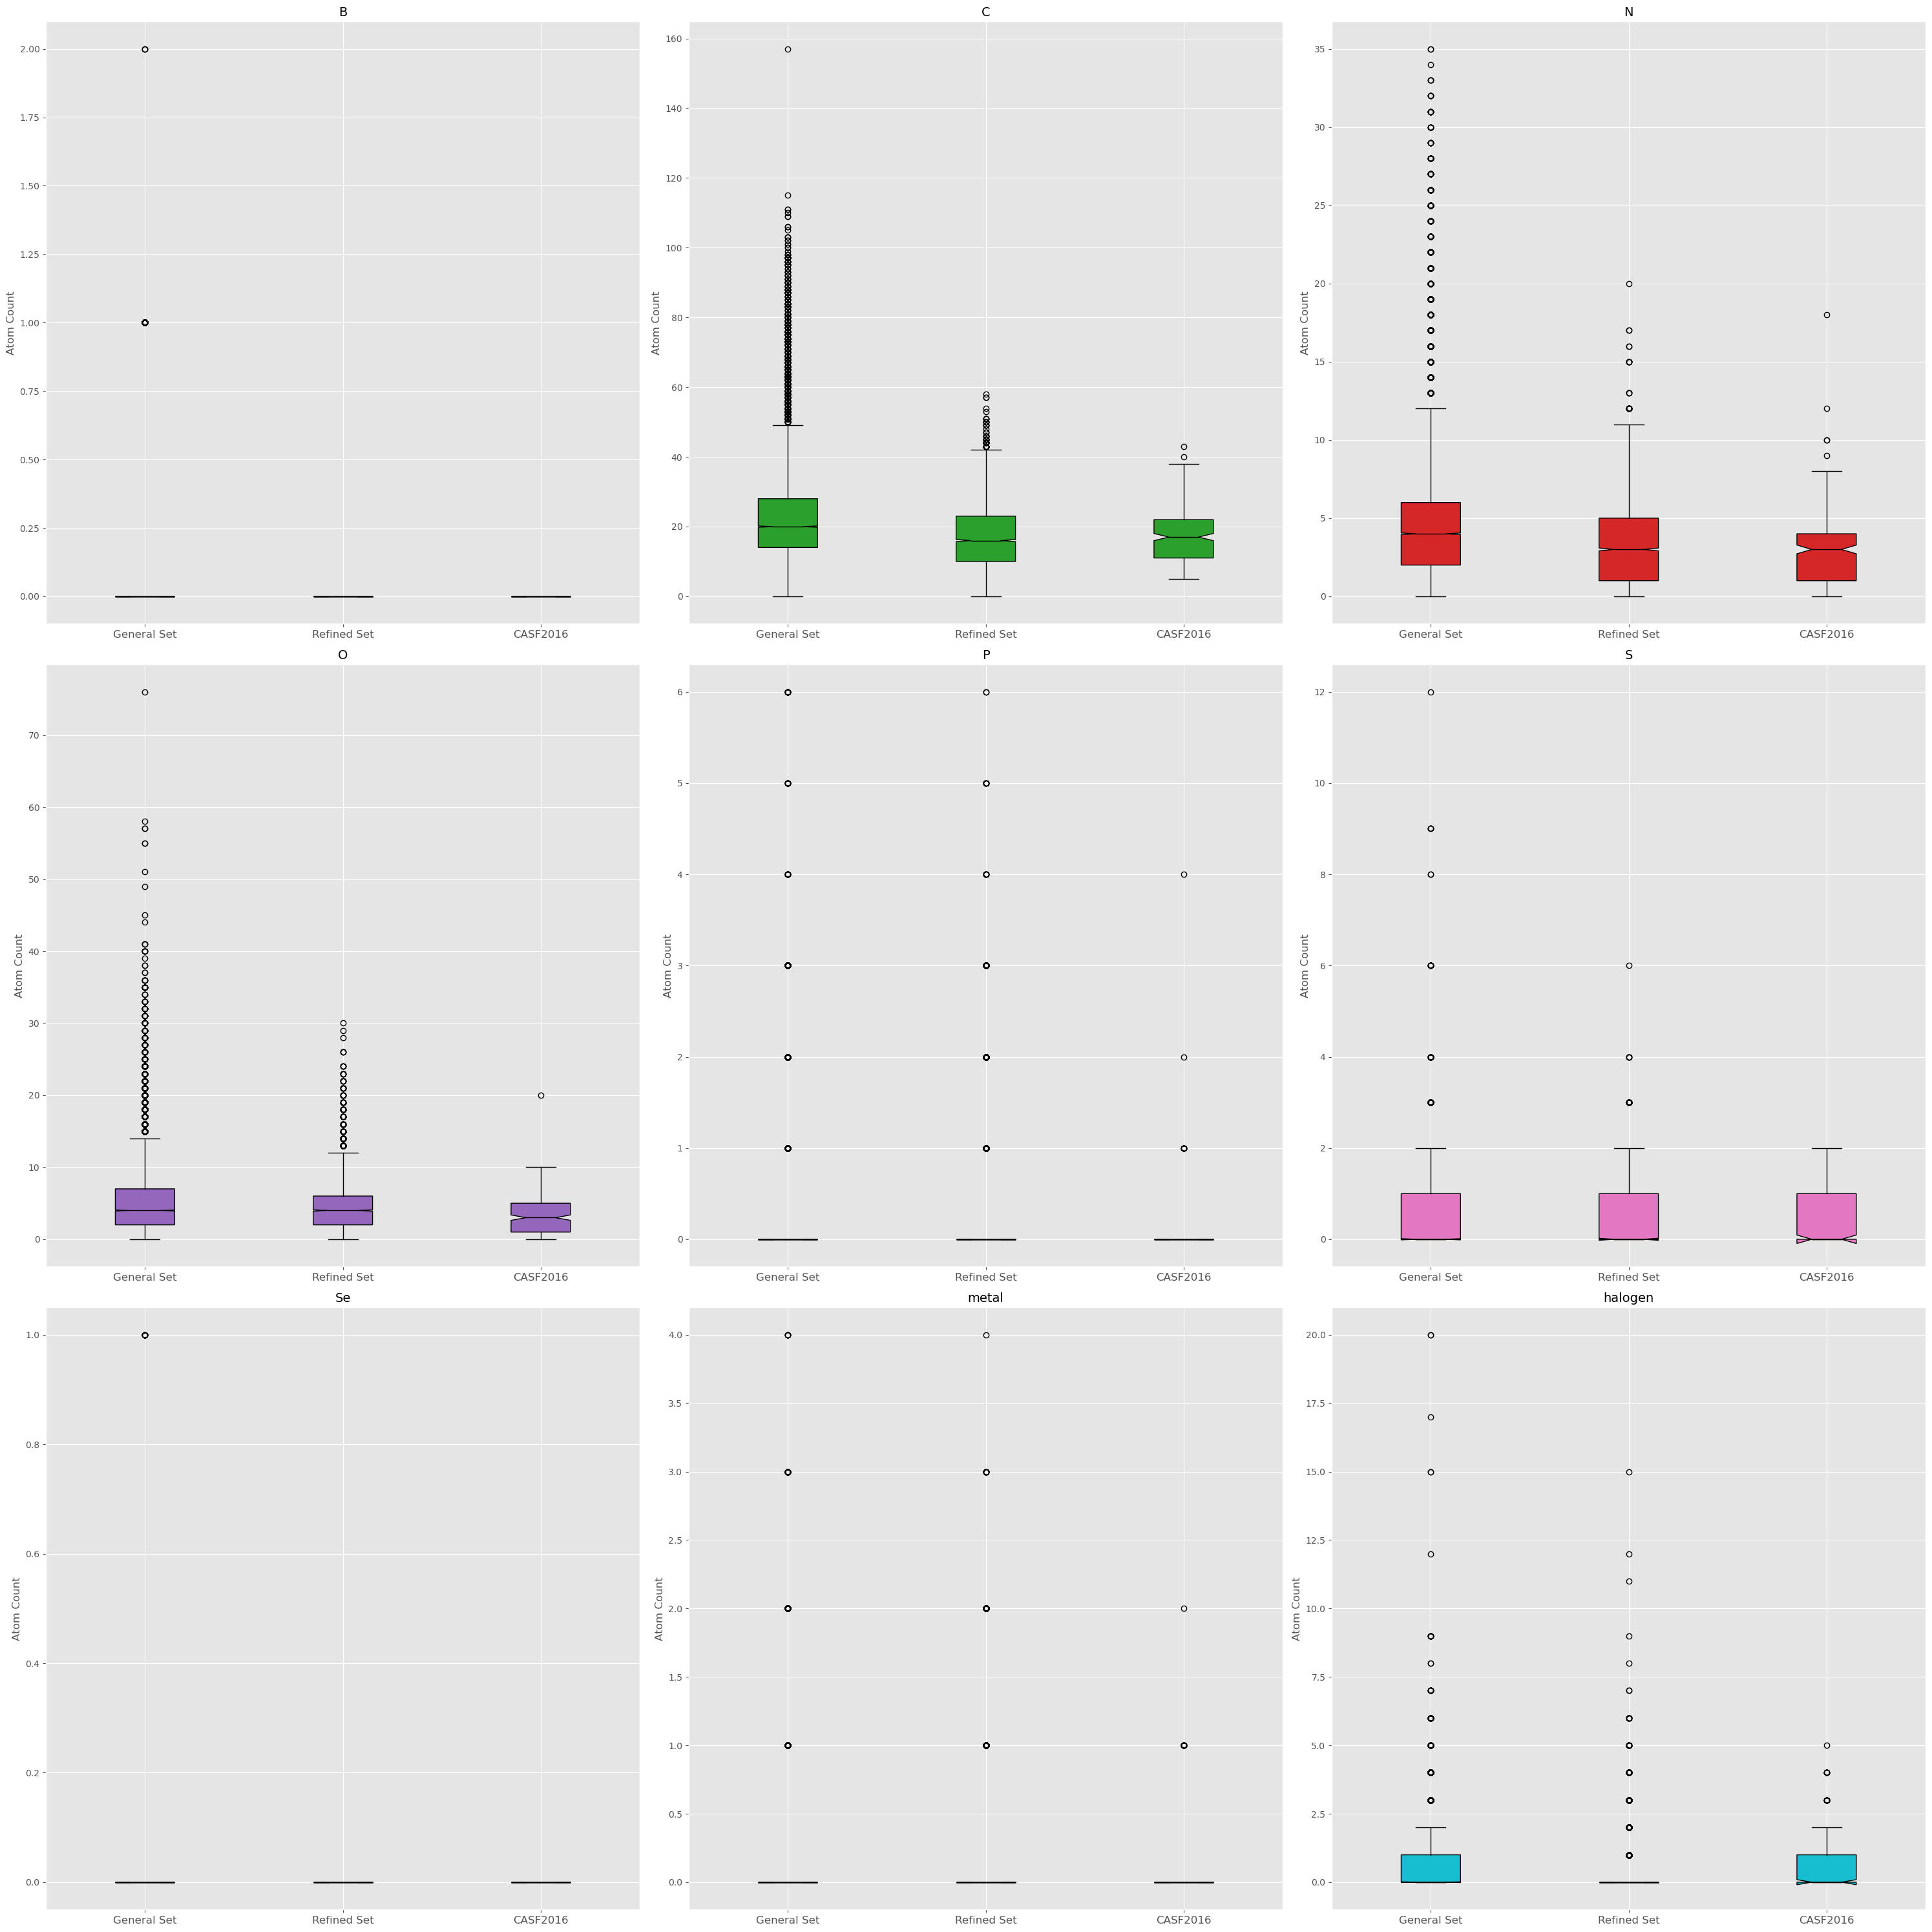

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

categories = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'metal', 'halogen']

# Setting up the figure size for the grid
plt.figure(figsize=(30, 30))

# Number of rows and columns in the grid
nrows, ncols = 3, 3

# Customizing the colors
colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors

# Loop over the grid and create boxplots
cg = 0
for i in range(1, nrows * ncols + 1):
    plt.subplot(nrows, ncols, i)

    # Create the boxplot
    bp = plt.boxplot(data[cg], patch_artist=True, notch=True, medianprops=dict(color="black"))

    # Coloring each box
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i % len(colors)])

    # Adding titles and labels
    plt.title(categories[cg], fontsize=14)
    plt.ylabel('Atom Count', fontsize=12)
    plt.xticks(ticks=range(1, len(data[cg]) + 1), labels=['General Set', 'Refined Set', 'CASF2016'], fontsize=12)

    cg += 1

# Adjust layout for a cleaner look
plt.tight_layout()

# Show the plot
plt.show()




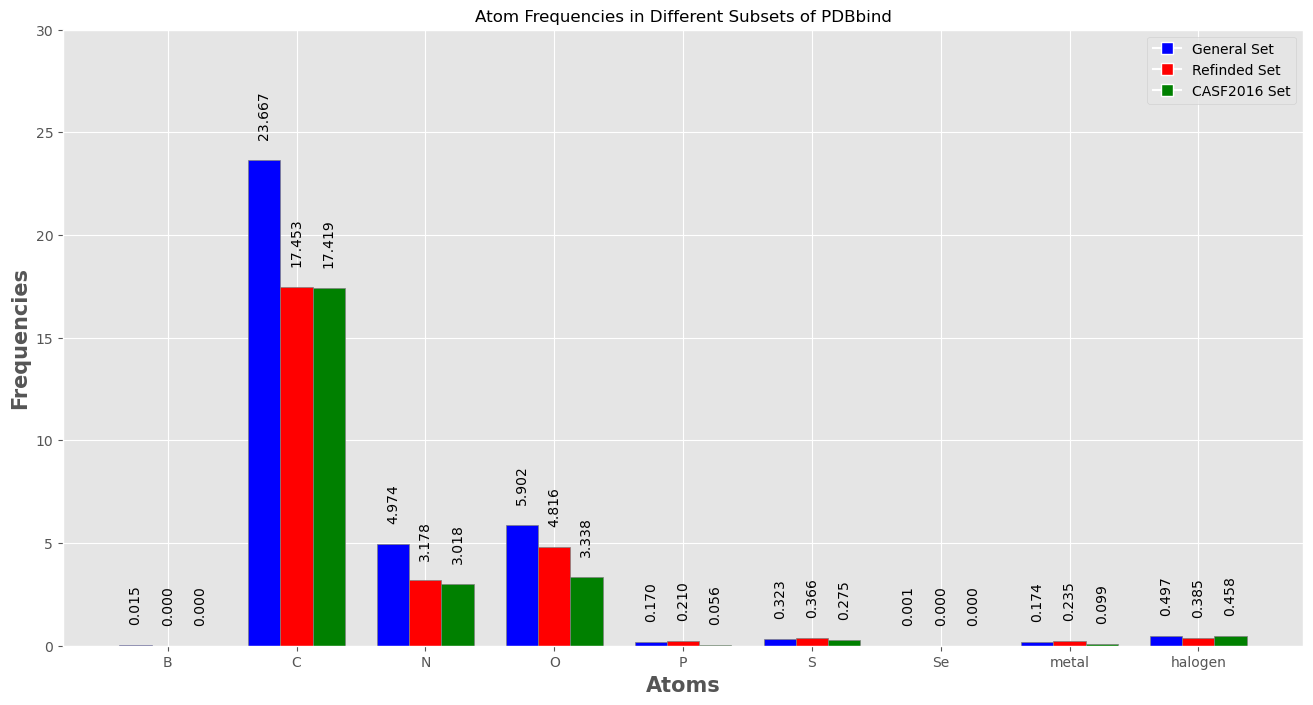

In [43]:

# X-axis categories
categories = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'metal', 'halogen']

# Setting up the figure and axes
fig, ax = plt.subplots(figsize=(16, 8))

# Width of a bar
bar_width = 0.25

# Positions of the bars
r1 = np.arange(len(general_atom_frequencies))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


# Creating bars and adding text on top
for idx in range(len(general_atom_frequencies)):
    ax.bar(r1[idx], general_atom_frequencies[idx], color='b', width=bar_width, edgecolor='grey', label='General Set')
    ax.text(r1[idx], general_atom_frequencies[idx]+1, f'{general_atom_frequencies[idx]:.3f}', ha='center', va='bottom', rotation=90)

for idx in range(len(refined_atom_frequencies)):
    ax.bar(r2[idx], refined_atom_frequencies[idx], color='r', width=bar_width, edgecolor='grey', label='Refined Set')
    ax.text(r2[idx], refined_atom_frequencies[idx]+1, f'{refined_atom_frequencies[idx]:.3f}', ha='center', va='bottom', rotation=90)

for idx in range(len(casf2016_atom_frequencies)):
    ax.bar(r3[idx], casf2016_atom_frequencies[idx], color='g', width=bar_width, edgecolor='grey', label='CASF2016 Test Set')
    ax.text(r3[idx], casf2016_atom_frequencies[idx]+1, f'{casf2016_atom_frequencies[idx]:.3f}', ha='center', va='bottom', rotation=90)

# Adding manual legend items for colors
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=8, label='General Set'))
legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=8, label='Refinded Set'))
legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=8, label='CASF2016 Set'))

plt.legend(handles=legend_elements, loc='upper right')

# Adding labels
ax.set_xlabel('Atoms', fontweight='bold', fontsize=15)
ax.set_ylabel('Frequencies', fontweight='bold', fontsize=15)
ax.set_title('Atom Frequencies in Different Subsets of PDBbind', fontsize=12)
ax.set_xticks([r + bar_width for r in range(len(general_atom_frequencies))])
ax.set_xticklabels(categories)
ax.set_ylim(0, 30)

plt.rcParams['figure.dpi']=300

# Show plot
plt.show()


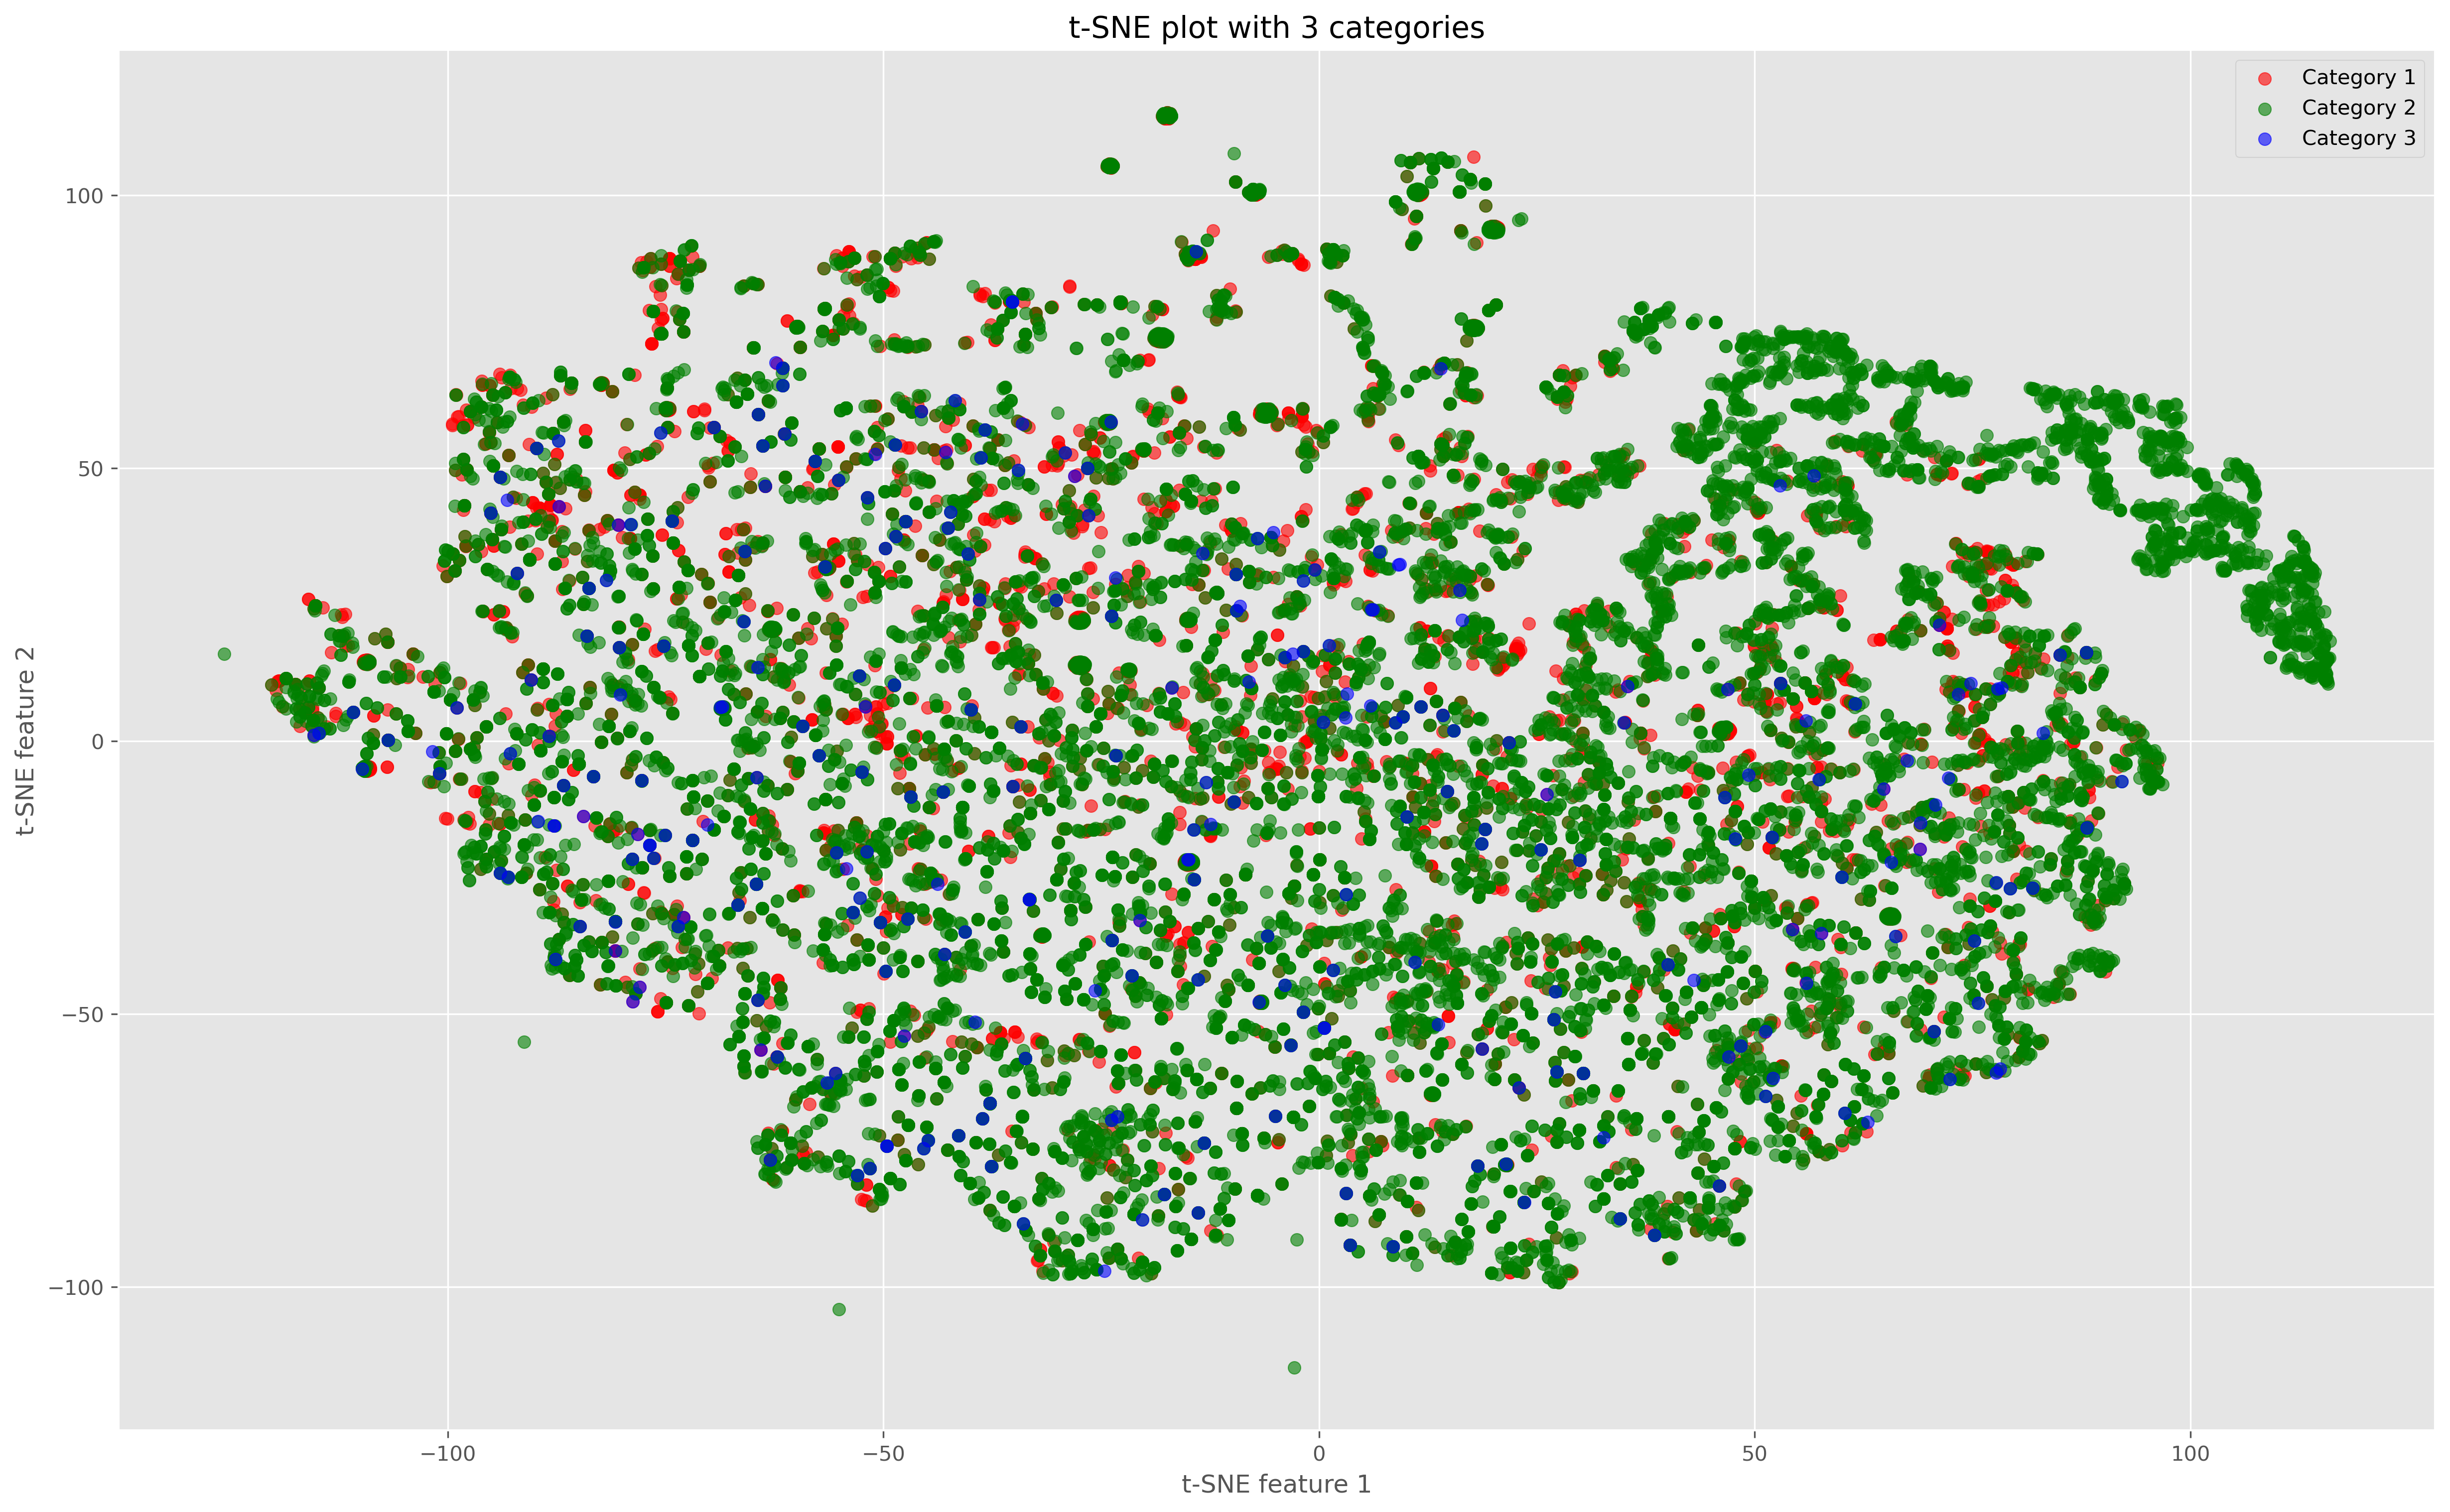

In [44]:
active_sites = torch.cat( [refined_atoms, general_atoms, casf2016_atoms] , axis = 0)

y = [0 for i in range(len(refined_atoms))]+[1 for i in range(len(general_atoms))]+[2 for i in range(len(casf2016_atoms))]
y = np.array(y)



import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Performing t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(active_sites.numpy())

# Plotting
plt.figure(figsize=(20, 12))

# Colors for each category
colors = ['red', 'green', 'blue']

# Plot each category
for i in range(3):
    mask = y == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=colors[i], label=f'Category {i+1}', alpha=0.6)

plt.title('t-SNE plot with 3 categories')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()